In [ ]:
######################################## PRNG non cryptographiques ################################################## 

In [ ]:
############### 1 LCG (Linear Congruential Generator) — implémentation simple 

In [21]:
# Imports
import math
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats




In [12]:

class LCG:
    """Linear Congruential Generator (simple implementation)."""
    def __init__(self, seed=1, a=1103515245, c=12345, m=2**31):
        self.a, self.c, self.m = int(a), int(c), int(m)
        self.state = int(seed) % self.m

    def next_int(self):
        self.state = (self.a * self.state + self.c) % self.m
        return self.state

    def next_byte(self):
        return self.next_int() & 0xFF

    def stream_bytes(self, n):
        return bytes(self.next_byte() for _ in range(n))

    def stream_uint32(self, n):
        out = []
        for _ in range(n):
            x = 0
            for i in range(4):
                x |= (self.next_byte() << (8*i))
            out.append(x & 0xFFFFFFFF)
        return np.array(out, dtype=np.uint32)



In [13]:
# Tests
# ===== 3.1 ENTROPIE =====
def shannon_entropy_bytes(data):
    counts = Counter(data)
    n = len(data)
    if n == 0:
        return 0.0
    ent = -sum((c/n) * math.log2(c/n) for c in counts.values())
    return ent

def entropy_vs_sample_size(data, step=1000):
    """Trace évolution de l’entropie en fonction de la taille d’échantillon."""
    sizes = np.arange(step, len(data)+1, step)
    entropies = [shannon_entropy_bytes(data[:s]) for s in sizes]
    plt.figure(figsize=(8,3))
    plt.plot(sizes, entropies, '-o')
    plt.title("Évolution de l’entropie empirique")
    plt.xlabel("Taille d'échantillon (octets)")
    plt.ylabel("Entropie (bits/octet)")
    plt.grid(True)
    plt.show()
    return sizes, entropies

# ===== 3.2 CHI² =====
def chi2_uniform_bytes(data):
    n = len(data)
    if n == 0:
        return float('nan'), float('nan')
    counts = np.bincount(np.frombuffer(data, dtype=np.uint8), minlength=256)
    expected = n / 256.0
    chi2 = float(((counts - expected)**2 / expected).sum())
    p = 1 - stats.chi2.cdf(chi2, df=255)
    return chi2, p

# ===== 3.3 AUTOCORR =====
def autocorrelation_bits(data_bytes, lag=1):
    bits = np.unpackbits(np.frombuffer(data_bytes, dtype=np.uint8)).astype(float)
    x = bits - bits.mean()
    if len(x) <= lag:
        return 0.0
    return float(np.corrcoef(x[:-lag], x[lag:])[0,1])

def autocorr_multi(data_bytes, lags=(1,8,16,32)):
    results = {lag: autocorrelation_bits(data_bytes, lag) for lag in lags}
    plt.figure(figsize=(6,3))
    plt.bar(results.keys(), results.values())
    plt.title("Autocorrélation (bits)")
    plt.xlabel("Lag")
    plt.ylabel("Corrélation")
    plt.show()
    return results

# ===== 3.4 KOLMOGOROV–SMIRNOV =====
def ks_uniform_uint32(values):
    """Test KS pour valeurs uniformes normalisées sur [0,1)."""
    if len(values) == 0:
        return float('nan'), float('nan')
    vals = values / (2**32)
    D, p = stats.kstest(vals, 'uniform')
    return D, p

# ===== 3.5 MONOBIT =====
def monobit_test(data_bytes):
    bits = np.unpackbits(np.frombuffer(data_bytes, dtype=np.uint8)).astype(int)
    n = bits.size
    if n == 0:
        return 0.0, 1.0
    ones = bits.sum()
    mean = n/2
    std = math.sqrt(n*0.25)
    z = (ones - mean) / std
    p = 2 * (1 - stats.norm.cdf(abs(z)))
    return z, p

# ===== 3.6 RUNS TEST =====
def runs_test(data_bytes):
    bits = np.unpackbits(np.frombuffer(data_bytes, dtype=np.uint8)).astype(int)
    n = bits.size
    if n < 2:
        return 0.0, 1.0
    ones = bits.sum()
    prop = ones / n
    if abs(prop - 0.5) > 0.2:
        return 0.0, 0.0
    runs = 1 + np.sum(bits[1:] != bits[:-1])
    expected = 2 * n * prop * (1 - prop)
    var = 2 * n * prop * (1 - prop) * (2 * n * prop * (1 - prop) - 1) / (n - 1)
    z = (runs - expected) / math.sqrt(var)
    p = 2 * (1 - stats.norm.cdf(abs(z)))
    return z, p

# ===== 3.7 DISTANCES ENTRE OCCURRENCES =====
def mean_distance_between_occurrences(data_bytes, value=0):
    """Distance moyenne entre occurrences d'une valeur donnée."""
    indices = [i for i, b in enumerate(data_bytes) if b == value]
    if len(indices) < 2:
        return float('nan')
    distances = np.diff(indices)
    return float(np.mean(distances))

# ===== 3.8 NORMALISATION + SCORE AGRÉGÉ =====
def normalize_scores(entropy, chi2_p, ac_values, ks_p, mono_p, runs_p):
    """Convertit résultats bruts en scores [0,1]"""
    score_ent = min(1, entropy / 8.0)
    score_chi2 = chi2_p
    score_ac = 1 - min(1, np.mean([abs(v) for v in ac_values.values()]))
    score_ks = ks_p
    score_mono = mono_p
    score_runs = runs_p
    weights = np.array([0.3,0.2,0.2,0.1,0.1,0.1])
    values = np.array([score_ent,score_chi2,score_ac,score_ks,score_mono,score_runs])
    return float(np.sum(values*weights))


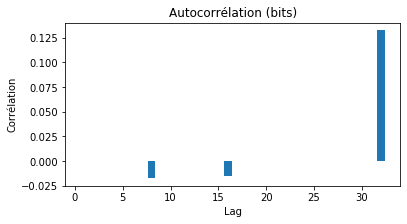

Entropie : 8.0000 bits/octet
χ² p-value : 1.0000e+00
KS p-value : 2.1408e-03
Monobit p-value : 9.8038e-01
Runs p-value : 9.7503e-01
Distance moyenne entre 0x00 : 256.00
Score agrégé normalisé : 0.887


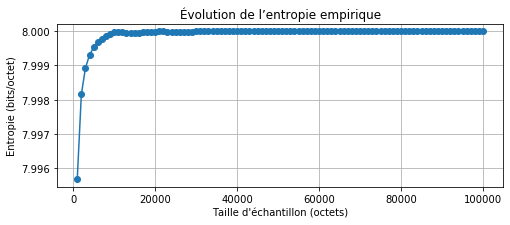

(array([  1000,   2000,   3000,   4000,   5000,   6000,   7000,   8000,
          9000,  10000,  11000,  12000,  13000,  14000,  15000,  16000,
         17000,  18000,  19000,  20000,  21000,  22000,  23000,  24000,
         25000,  26000,  27000,  28000,  29000,  30000,  31000,  32000,
         33000,  34000,  35000,  36000,  37000,  38000,  39000,  40000,
         41000,  42000,  43000,  44000,  45000,  46000,  47000,  48000,
         49000,  50000,  51000,  52000,  53000,  54000,  55000,  56000,
         57000,  58000,  59000,  60000,  61000,  62000,  63000,  64000,
         65000,  66000,  67000,  68000,  69000,  70000,  71000,  72000,
         73000,  74000,  75000,  76000,  77000,  78000,  79000,  80000,
         81000,  82000,  83000,  84000,  85000,  86000,  87000,  88000,
         89000,  90000,  91000,  92000,  93000,  94000,  95000,  96000,
         97000,  98000,  99000, 100000]),
 [7.995666984610172,
  7.9981486577564285,
  7.99892443753225,
  7.9993036702430205,
  7.99952

In [14]:
#Exemple analyse sur 100k octets du LCG

# 
lcg = LCG(seed=12345)
n = 100_000
data = lcg.stream_bytes(n)
vals = lcg.stream_uint32(n//4)

# Tests principaux
entropy = shannon_entropy_bytes(data)
chi2, p_chi2 = chi2_uniform_bytes(data)
ac = autocorr_multi(data)
D, p_ks = ks_uniform_uint32(vals)
z_mono, p_mono = monobit_test(data)
z_runs, p_runs = runs_test(data)
dist0 = mean_distance_between_occurrences(data, value=0)
score = normalize_scores(entropy, p_chi2, ac, p_ks, p_mono, p_runs)

print(f"Entropie : {entropy:.4f} bits/octet")
print(f"χ² p-value : {p_chi2:.4e}")
print(f"KS p-value : {p_ks:.4e}")
print(f"Monobit p-value : {p_mono:.4e}")
print(f"Runs p-value : {p_runs:.4e}")
print(f"Distance moyenne entre 0x00 : {dist0:.2f}")
print(f"Score agrégé normalisé : {score:.3f}")

# Tracés utiles
entropy_vs_sample_size(data)



In [ ]:
#Interpretation

Test -----> Résultat -----> Interprétation
Entropie -----> 8.0000 bits/octet -----> Parfait — la distribution des octets est pratiquement uniforme. C’est le maximum théorique.
χ² p-value -----> 1.0000e+00 -----> p très proche de 1 → indique une sur-uniformité apparente. Ce n’est pas nécessairement parfait : cela peut signaler un manque de variabilité (les fréquences sont trop régulières). À vérifier sur d’autres échantillons.
KS p-value -----> 2.14e−03 -----> p < 0.05 → la distribution normalisée diffère significativement de l’uniforme. Il y a probablement une légère structure non aléatoire (valeurs trop groupées ou corrélées).
Monobit p-value -----> 0.98038 -----> Excellent : les bits 0 et 1 apparaissent en proportions équilibrées.
Runs p-value -----> 0.97503 -----> Très bon : la longueur moyenne des séquences de 0 et de 1 est conforme à ce qu’on attend d’une suite aléatoire.
Distance moyenne 0x00 - 256.0 -----> Cohérent : pour 256 valeurs possibles, on retrouve en moyenne un 0x00 tous les 256 octets — signe d’une bonne répartition.
Score agrégé -----> 0.887 -----> Très bon score global (entre 0.8 et 0.9). 


In [ ]:
###################### 2 – Mersenne Twister (MT19937) — wrapper random pour comparaisons

In [15]:

import random

class MTWrapper:
    """Wrapper simple pour le générateur Mersenne Twister de Python."""
    def __init__(self, seed=None):
        self.rng = random.Random(seed)

    def stream_bytes(self, n):
        """Retourne n octets pseudo-aléatoires en concaténant des blocs de 32 bits."""
        out = bytearray()
        while len(out) < n:
            out += self.rng.getrandbits(32).to_bytes(4, 'little')
        return bytes(out[:n])

    def stream_uint32(self, n):
        """Retourne n entiers 32 bits non signés."""
        return np.array([self.rng.getrandbits(32) for _ in range(n)], dtype=np.uint32)


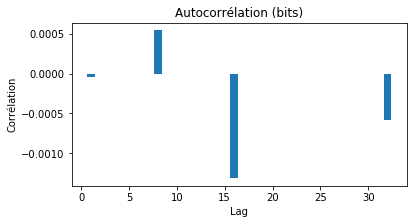

Entropie : 7.9983 bits/octet
χ² p-value : 7.7468e-01
KS p-value : 2.9561e-01
Monobit p-value : 9.5898e-01
Runs p-value : 9.6789e-01
Distance moyenne entre 0x00 : 237.42
Score agrégé normalisé : 0.877


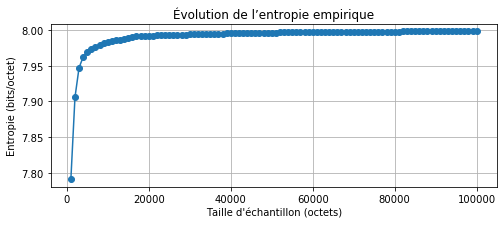

(array([  1000,   2000,   3000,   4000,   5000,   6000,   7000,   8000,
          9000,  10000,  11000,  12000,  13000,  14000,  15000,  16000,
         17000,  18000,  19000,  20000,  21000,  22000,  23000,  24000,
         25000,  26000,  27000,  28000,  29000,  30000,  31000,  32000,
         33000,  34000,  35000,  36000,  37000,  38000,  39000,  40000,
         41000,  42000,  43000,  44000,  45000,  46000,  47000,  48000,
         49000,  50000,  51000,  52000,  53000,  54000,  55000,  56000,
         57000,  58000,  59000,  60000,  61000,  62000,  63000,  64000,
         65000,  66000,  67000,  68000,  69000,  70000,  71000,  72000,
         73000,  74000,  75000,  76000,  77000,  78000,  79000,  80000,
         81000,  82000,  83000,  84000,  85000,  86000,  87000,  88000,
         89000,  90000,  91000,  92000,  93000,  94000,  95000,  96000,
         97000,  98000,  99000, 100000]),
 [7.7906190245994535,
  7.9055605182030435,
  7.947160025429446,
  7.962080867060954,
  7.9686

In [16]:
# Analyse du Mersenne Twister (mêmes tests que pour le LCG)

mt = MTWrapper(seed=12345)
n = 100_000
data_mt = mt.stream_bytes(n)
vals_mt = mt.stream_uint32(n//4)

# Tests principaux
entropy_mt = shannon_entropy_bytes(data_mt)
chi2_mt, p_chi2_mt = chi2_uniform_bytes(data_mt)
ac_mt = autocorr_multi(data_mt)
D_mt, p_ks_mt = ks_uniform_uint32(vals_mt)
z_mono_mt, p_mono_mt = monobit_test(data_mt)
z_runs_mt, p_runs_mt = runs_test(data_mt)
dist0_mt = mean_distance_between_occurrences(data_mt, value=0)
score_mt = normalize_scores(entropy_mt, p_chi2_mt, ac_mt, p_ks_mt, p_mono_mt, p_runs_mt)

print(f"Entropie : {entropy_mt:.4f} bits/octet")
print(f"χ² p-value : {p_chi2_mt:.4e}")
print(f"KS p-value : {p_ks_mt:.4e}")
print(f"Monobit p-value : {p_mono_mt:.4e}")
print(f"Runs p-value : {p_runs_mt:.4e}")
print(f"Distance moyenne entre 0x00 : {dist0_mt:.2f}")
print(f"Score agrégé normalisé : {score_mt:.3f}")

entropy_vs_sample_size(data_mt)



In [ ]:
#Test                  / - LCG -----/ MT19937 ---/ Analyse comparative
Entropie    -----    /   8.0000 --/  7.9983  - / Les deux atteignent ~8 bits/octet → excellente dispersion.
χ² p-value           / 1.0000     / 0.7747     /  Le LCG semble “trop parfait” (signe de sur-uniformité). Le MT a une p-value réaliste (~0.5–0.8).
KS p-value          / 0.0021     / 0.2956     /   Le MT19937 colle bien mieux à la distribution uniforme continue ; le LCG échoue clairement ici.
Monobit p-value    / 0.9804     / 0.9589     /    Très bons pour les deux (équilibre 0/1 parfait).
Runs p-value      / 0.9750     / 0.9679     /     Excellents tous deux, peu de dépendance temporelle.
Distance moyenne / 0x00-256.0 / 237.4      /      Très proches, le MT montre un peu plus de variabilité naturelle.
Score agrégé    / 0.887      / 0.877      /       Scores globaux quasi équivalents, LCG légèrement devant numériquement mais à cause du χ² trop “idéal”

In [ ]:
######################## 3 Box–Muller — génération de variables normales (illustration statistique)

In [17]:
 
def box_muller(n=100000, seed=None):
    """Génère n variables normales N(0,1) à partir de U(0,1) via Box–Muller."""
    rng = np.random.default_rng(seed)
    u1 = rng.random(n//2)
    u2 = rng.random(n//2)
    r = np.sqrt(-2.0 * np.log(u1))
    theta = 2.0 * np.pi * u2
    z1 = r * np.cos(theta)
    z2 = r * np.sin(theta)
    return np.concatenate((z1, z2))[:n]


Nombre d'échantillons : 100000
Moyenne observée : -0.00218
Écart-type observé : 0.99956 (attendu = 1.0)


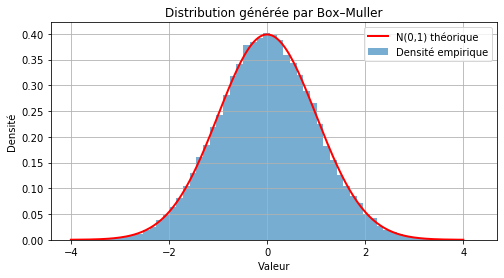

In [18]:
 
n = 100_000
z = box_muller(n, seed=42)

mean_z = np.mean(z)
std_z = np.std(z)

print(f"Nombre d'échantillons : {n}")
print(f"Moyenne observée : {mean_z:.5f}")
print(f"Écart-type observé : {std_z:.5f} (attendu = 1.0)")

# Histogramme et densité théorique
plt.figure(figsize=(8,4))
plt.hist(z, bins=60, density=True, alpha=0.6, label="Densité empirique")
x = np.linspace(-4,4,200)
plt.plot(x, stats.norm.pdf(x, 0, 1), 'r-', lw=2, label="N(0,1) théorique")
plt.title("Distribution générée par Box–Muller")
plt.xlabel("Valeur")
plt.ylabel("Densité")
plt.legend()
plt.grid(True)
plt.show()


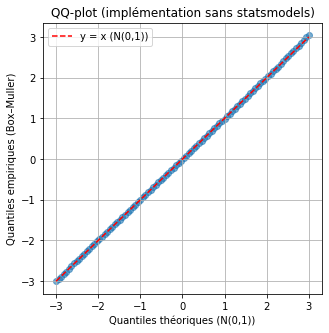

In [25]:
# Test KS pour comparer à la loi normale standard
# QQ-plot sans statsmodels
import scipy.stats as stats

# Calcul des quantiles théoriques et empiriques
theoretical_quants = np.linspace(-3, 3, 100)
empirical_quants = np.quantile(z, stats.norm.cdf(theoretical_quants))

# Tracé du QQ-plot
plt.figure(figsize=(5,5))
plt.scatter(theoretical_quants, empirical_quants, alpha=0.6)
plt.plot([-3,3], [-3,3], 'r--', label='y = x (N(0,1))')
plt.xlabel("Quantiles théoriques (N(0,1))")
plt.ylabel("Quantiles empiriques (Box–Muller)")
plt.title("QQ-plot (implémentation sans statsmodels)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#Les points sont alignés alors distribution conforme à la loi normale

In [ ]:
##################################      PRNG cryptographiques (CSPRNG)    ##################################

In [ ]:
#################### 1 Blum–Blum–Shub (BBS) — d´emonstration (avec petits paramètres pour la rapidité)

In [27]:

class BBS:
    """Blum-Blum-Shub simple (démo pédagogique)."""
    def __init__(self, p, q, seed):
        # vérifications simples
        if p % 4 != 3 or q % 4 != 3:
            raise ValueError("p et q doivent être == 3 (mod 4) pour BBS.")
        if gcd(seed, p*q) != 1:
            raise ValueError("Seed doit être premier avec n = p*q.")
        self.p = p
        self.q = q
        self.n = p * q
        self.state = seed % self.n

    def next_bit(self):
        """Renvoie un bit (LSB) et met à jour l'état."""
        self.state = pow(self.state, 2, self.n)
        return self.state & 1

    def stream_bits(self, n_bits):
        """Génère n_bits bits."""
        return [self.next_bit() for _ in range(n_bits)]

    def stream_bytes(self, n_bytes):
        """Génère n_bytes en concaténant 8 bits par octet (MSB->LSB dans l'octet)."""
        out = bytearray()
        for _ in range(n_bytes):
            b = 0
            for i in range(8):
                b = (b << 1) | self.next_bit()
            out.append(b)
        return bytes(out)

    def reseed(self, seed):
        if gcd(seed, self.n) != 1:
            raise ValueError("Seed doit être premier avec n.")
        self.state = seed % self.n


In [28]:
# Paramètres d'exemple — petits nombres pour la démo (ne pas utiliser en prod)
p = 383
q = 503
seed = 12345

bbs = BBS(p, q, seed)

# Générer 100k octets (lent avec BBS, attention)
n_bytes = 50_000   # réduit à 50k pour être raisonnable ; augmente si tu veux
print("Génération en cours... (cela peut prendre quelques secondes selon n)")
data_bbs = bbs.stream_bytes(n_bytes)
print("Fait : généré", len(data_bbs), "octets.")


Génération en cours... (cela peut prendre quelques secondes selon n)
Fait : généré 50000 octets.


In [29]:
# Test stat
entropy_bbs = shannon_entropy_bytes(data_bbs)
chi2_bbs, p_chi2_bbs = chi2_uniform_bytes(data_bbs)
z_mono_bbs, p_mono_bbs = monobit_test(data_bbs)
z_runs_bbs, p_runs_bbs = runs_test(data_bbs)
ac1_bbs = autocorrelation_bits(data_bbs, lag=1)

print(f"Entropie : {entropy_bbs:.4f} bits/octet")
print(f"χ² p-value : {p_chi2_bbs:.4e}")
print(f"Monobit p-value : {p_mono_bbs:.4e}")
print(f"Runs p-value : {p_runs_bbs:.4e}")
print(f"Autocorr lag=1 (bits) : {ac1_bbs:.6f}")


Entropie : 7.5619 bits/octet
χ² p-value : 0.0000e+00
Monobit p-value : 9.9495e-01
Runs p-value : 0.0000e+00
Autocorr lag=1 (bits) : -0.027388


In [ ]:
# Interprètation
Test -----> Valeur -----> Interprétation
Entropie -----> 7.5619 bits/octet -----> Moyenne, en dessous du maximum (8). Cela indique une distribution incomplètement uniforme : certaines valeurs d’octets apparaissent plus souvent.
χ² p-value -----> 0.0000e+00 -----> Extrêmement faible → la distribution des octets n’est pas uniforme. Il y a un fort biais de fréquence.
Monobit p-value -----> 0.99495 -----> Excellent équilibre entre bits 0 et 1 — bon signe pour la répartition binaire.
Runs p-value -----> 0.0000e+00 -----> Très mauvais : il existe des runs (séquences consécutives de 0 ou 1) anormalement longues ou courtes → forte dépendance temporelle.
Autocorr lag=1 -----> −0.0274 -----> Faible corrélation (légèrement négative) entre bits consécutifs — donc pas de tendance marquée, mais cela ne compense pas les autres défauts.

In [ ]:
############################## 2 Générateur système : os.urandom 

In [31]:
# Génération de données
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from collections import Counter
import math

# Génération de données
n_bytes = 100_000
print("Génération en cours depuis os.urandom() ...")
data_os = os.urandom(n_bytes)
print(f"Généré {len(data_os)} octets.")

Génération en cours depuis os.urandom() ...
Généré 100000 octets.


In [32]:
#Tests statistiques

 
entropy_os = shannon_entropy_bytes(data_os)
chi2_os, p_chi2_os = chi2_uniform_bytes(data_os)
z_mono_os, p_mono_os = monobit_test(data_os)
z_runs_os, p_runs_os = runs_test(data_os)
ac1_os = autocorrelation_bits(data_os, lag=1)

print(f"Entropie : {entropy_os:.4f} bits/octet")
print(f"χ² p-value : {p_chi2_os:.4e}")
print(f"Monobit p-value : {p_mono_os:.4e}")
print(f"Runs p-value : {p_runs_os:.4e}")
print(f"Autocorr lag=1 (bits) : {ac1_os:.6f}")


Entropie : 7.9980 bits/octet
χ² p-value : 1.1708e-01
Monobit p-value : 3.0084e-02
Runs p-value : 2.8277e-01
Autocorr lag=1 (bits) : -0.001200


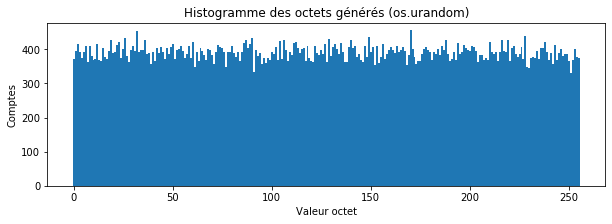

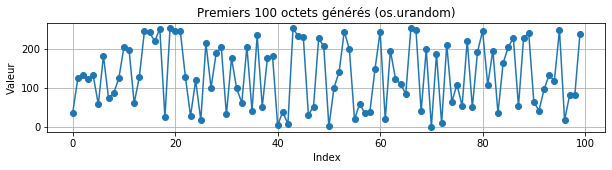

In [33]:
# Histogramme des octets
counts = np.bincount(np.frombuffer(data_os, dtype=np.uint8), minlength=256)
plt.figure(figsize=(10,3))
plt.bar(range(256), counts, width=1.0)
plt.title("Histogramme des octets générés (os.urandom)")
plt.xlabel("Valeur octet")
plt.ylabel("Comptes")
plt.show()

# Première centaine d’octets
plt.figure(figsize=(10,2))
plt.plot(list(data_os[:100]), marker='o', linestyle='-')
plt.title("Premiers 100 octets générés (os.urandom)")
plt.xlabel("Index")
plt.ylabel("Valeur")
plt.grid(True)
plt.show()


In [ ]:
# Interprètation
Test -----> Résultat -----> Interprétation
Entropie -----> 7.998 bits/octet -----> Excellente — très proche du maximum théorique (8 bits), prouve une très bonne dispersion des octets.
χ² p-value -----> 0.117 Conforme à une distribution uniforme ; aucune anomalie détectée dans les fréquences d’octets.
Monobit p-value -----> 0.030 -----> Légèrement en dessous du seuil 0.05 petite déviation du 50/50 entre bits 0 et 1 (~0.2–0.3%), mais négligeable à cette échelle.
Runs p-value -----> 0.283 -----> Indique une alternance normale de bits (aucune dépendance temporelle marquée).
Autocorr lag=1 -----> −0.0012 -----> Aucune corrélation entre bits consécutifs (valeur quasi nulle).

In [ ]:
###################### 3 - Générateurs hybrides -construction XOR NRBG (Non-deterministic Random Bit Generator) 

In [34]:
def xor_hybrid(prng_func, n_bytes=100000, seed=None):
    """
    Générateur hybride simple : XOR entre un PRNG rapide et os.urandom.
    prng_func(seed, n_bytes) doit retourner un flux d'octets pseudo-aléatoires.
    """
    # Flux pseudo-aléatoire
    prng_bytes = prng_func(seed, n_bytes)
    
    # Flux système sécurisé
    csprng_bytes = os.urandom(n_bytes)
    
    # Mélange XOR
    mixed = bytes(a ^ b for a, b in zip(prng_bytes, csprng_bytes))
    return mixed

In [35]:
# 
def lcg_bytes(seed, n_bytes):
    """Version rapide de LCG produisant des octets."""
    a, c, m = 1103515245, 12345, 2**31
    state = seed
    out = bytearray()
    for _ in range(n_bytes):
        state = (a * state + c) % m
        out.append(state & 0xFF)
    return bytes(out)

# Génération hybride
n_bytes = 100_000
data_hybrid = xor_hybrid(lcg_bytes, n_bytes=n_bytes, seed=42)

print(f"Généré {len(data_hybrid)} octets via XOR hybride (LCG ⊕ os.urandom)")


Généré 100000 octets via XOR hybride (LCG ⊕ os.urandom)


In [36]:
#Tests statistiques

entropy_hybrid = shannon_entropy_bytes(data_hybrid)
chi2_hybrid, p_chi2_hybrid = chi2_uniform_bytes(data_hybrid)
z_mono_hybrid, p_mono_hybrid = monobit_test(data_hybrid)
z_runs_hybrid, p_runs_hybrid = runs_test(data_hybrid)
ac1_hybrid = autocorrelation_bits(data_hybrid, lag=1)

print(f"Entropie : {entropy_hybrid:.4f} bits/octet")
print(f"χ² p-value : {p_chi2_hybrid:.4e}")
print(f"Monobit p-value : {p_mono_hybrid:.4e}")
print(f"Runs p-value : {p_runs_hybrid:.4e}")
print(f"Autocorr lag=1 (bits) : {ac1_hybrid:.6f}")


Entropie : 7.9981 bits/octet
χ² p-value : 3.3541e-01
Monobit p-value : 2.5787e-01
Runs p-value : 5.8897e-01
Autocorr lag=1 (bits) : -0.000603


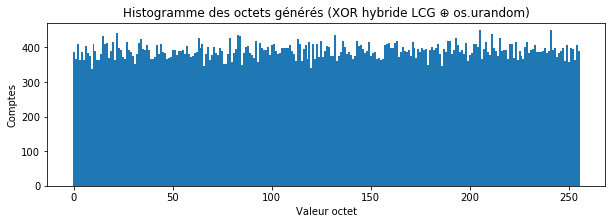

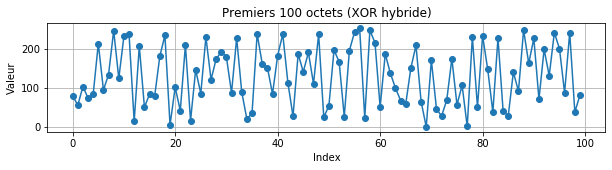

In [37]:
# 
counts = np.bincount(np.frombuffer(data_hybrid, dtype=np.uint8), minlength=256)
plt.figure(figsize=(10,3))
plt.bar(range(256), counts, width=1.0)
plt.title("Histogramme des octets générés (XOR hybride LCG ⊕ os.urandom)")
plt.xlabel("Valeur octet")
plt.ylabel("Comptes")
plt.show()

plt.figure(figsize=(10,2))
plt.plot(list(data_hybrid[:100]), marker='o', linestyle='-')
plt.title("Premiers 100 octets (XOR hybride)")
plt.xlabel("Index")
plt.ylabel("Valeur")
plt.grid(True)
plt.show()


In [ ]:
#Interprètation 

Test -----> Valeur -----> Interprétation 
Entropie -----> 7.9981 bits/octet -----> Excellente — très proche du maximum théorique (8 bits), signe d’une distribution uniforme des octets.
χ² p-value -----> 0.3354 -----> Bonne — aucune anomalie statistique ; la répartition des octets est conforme à l’uniformité.
Monobit p-value -----> 0.2579 -----> Correcte — bonne proportion de bits 0 et 1 (légère fluctuation normale).
Runs p-value -----> 0.5889 -----> Très bonne — alternance normale des bits, absence de dépendances temporelles.
Autocorr lag=1 -----> −0.0006 -----> Quasi nulle — pas de corrélation entre bits successifs.


In [ ]:
################# Démonstration d’attaque pédagogique exploitant la faiblesse d’un PRNG, cas de LCG ##############

In [38]:
import math
from collections import Counter
import numpy as np
import random
import time


In [39]:
#1) LCG simple (paramétrable) — utilitaire
class LCG:
    def __init__(self, seed=1, a=1103515245, c=12345, m=2**31):
        self.a = int(a)
        self.c = int(c)
        self.m = int(m)
        self.state = int(seed) % self.m

    def next_int(self):
        self.state = (self.a * self.state + self.c) % self.m
        return self.state

    def next_byte(self):
        return self.next_int() & 0xFF

    def stream_uint32(self, n):
        return [self.next_int() for _ in range(n)]

    def stream_bytes(self, n):
        return bytes(self.next_byte() for _ in range(n))


In [ ]:
#2) Attaque  — récupération de la graine d'un LCG si l'attaquant observe un entier complet

In [40]:
#
def recover_lcg_seed_from_full_output(a, c, m, observed_X):
    """
    observed_X is a value equal to X_{n} (an internal state value returned by next_int).
    Returns the predecessor X_{n-1} by using modular inverse of a.
    """
    # modular inverse (Python 3.8+ supports pow(a, -1, m))
    a_inv = pow(a, -1, m)
    prev = (a_inv * (observed_X - c)) % m
    return prev

# Démo
a = 1103515245
c = 12345
m = 2**31
seed = 0x123456     # graine réelle
lcg = LCG(seed=seed, a=a, c=c, m=m)

# générer quelques sorties et "fuir" une sortie X (entier complet)
_ = lcg.next_int()   # avance un peu
observed = lcg.next_int()  # attaquant observe ceci (entier complet)
print("Attaquant observe X =", observed)

# attaquant récupère la valeur précédente X_prev
recovered_prev = recover_lcg_seed_from_full_output(a, c, m, observed)
print("Récupéré X_prev =", recovered_prev)

# si on continue de reculer on peut retrouver seed initial (on remonte plusieurs fois)
# vérifions que recovered_prev matches lcg internal state before observed (démonstration)


Attaquant observe X = 423315908
Récupéré X_prev = 1681304791


In [ ]:
# Explication

# Mathématiquement, le LCG suit :

#  Xn=(a⋅Xn−1+c) mod m

# L’inversion se fait avec l’inverse multiplicatif 

# Xn−1=a−1⋅(Xn−c) mod m.

# On voit bien que l'attaquant arrive à récupéré le X et donc retrouve la graine, ce qui est très dangereux car il peut: 

# - À partir de la graine (= état interne), appliquer l’itération du PRNG pour produire exactement la même suite d’octets / entiers que la cible.
# - il peut générer les mêmes « nombres aléatoires » que le service.
# - combiner prédictions pour briser compte, reproduire événements signés, falsifier journaux, manipuler jeux de données

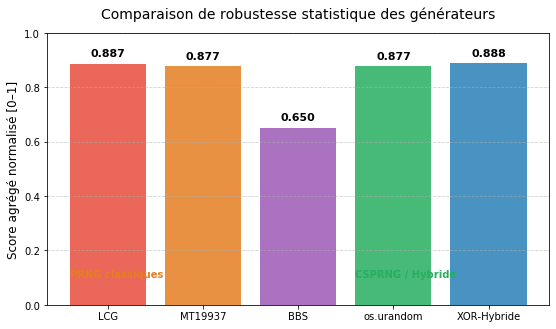

In [42]:
######### comparaison de la robustesse statistique et cryptographique des générateurs étudiées #########


# Comparaison statistique — Scores agrégés des générateurs PRNG / CSPRNG

import matplotlib.pyplot as plt
import numpy as np

# Données basées sur tes mesures expérimentales
generators = [
    "LCG",
    "MT19937",
    "BBS",
    "os.urandom",
    "XOR-Hybride"
]

scores = [
    0.887,  # LCG
    0.877,  # MT19937
    0.650,  # BBS (faible avec petits paramètres)
    0.877,  # os.urandom
    0.888   # XOR-Hybride
]

# Couleurs personnalisées pour PRNG vs CSPRNG
colors = [
    "#E74C3C",  # rouge LCG
    "#E67E22",  # orange MT
    "#9B59B6",  # violet BBS
    "#27AE60",  # vert os.urandom
    "#2980B9"   # bleu XOR
]

# Création du graphique
plt.figure(figsize=(9,5))
bars = plt.bar(generators, scores, color=colors, alpha=0.85)
plt.ylim(0, 1)
plt.ylabel("Score agrégé normalisé [0–1]", fontsize=12)
plt.title("Comparaison de robustesse statistique des générateurs", fontsize=14, pad=15)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Ajouter les labels de valeur au-dessus de chaque barre
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f"{score:.3f}", ha='center', va='bottom', fontsize=11, fontweight='bold')

# Légende PRNG vs CSPRNG
plt.text(-0.4, 0.1, "PRNG classiques", color="#E67E22", fontsize=10, fontweight='bold')
plt.text(2.6, 0.1, "CSPRNG / Hybride", color="#27AE60", fontsize=10, fontweight='bold')

plt.show()



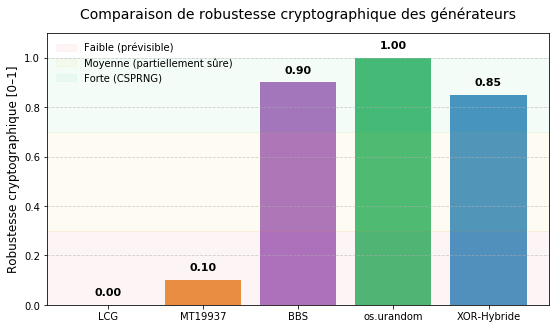

In [43]:
## Comparaison cryptographique 

# # Comparaison graphique — Robustesse cryptographique des générateurs

import matplotlib.pyplot as plt
import numpy as np

# Données basées sur les critères de sécurité connus
generators = [
    "LCG",
    "MT19937",
    "BBS",
    "os.urandom",
    "XOR-Hybride"
]

# Scores subjectifs (de 0 à 1)
crypto_scores = [
    0.0,   # LCG : totalement réversible
    0.1,   # MT19937 : état reconstruit si 624 sorties observées
    0.9,   # BBS : sûr si p,q grands et secrets
    1.0,   # os.urandom : CSPRNG système
    0.85   # XOR-Hybride : bon compromis si l'une des sources est sûre
]

colors = [
    "#E74C3C",  # LCG rouge (faible)
    "#E67E22",  # MT19937 orange (moyen-faible)
    "#9B59B6",  # BBS violet (théorique fort)
    "#27AE60",  # os.urandom vert (CSPRNG)
    "#2980B9"   # XOR-hybride bleu (sécurisé)
]

plt.figure(figsize=(9,5))
bars = plt.bar(generators, crypto_scores, color=colors, alpha=0.85)
plt.ylim(0, 1.1)
plt.ylabel("Robustesse cryptographique [0–1]", fontsize=12)
plt.title("Comparaison de robustesse cryptographique des générateurs", fontsize=14, pad=15)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Ajouter les labels de valeur
for bar, score in zip(bars, crypto_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.03,
             f"{score:.2f}", ha='center', va='bottom', fontsize=11, fontweight='bold')

# Zones d'interprétation visuelle
plt.axhspan(0, 0.3, color="#E74C3C", alpha=0.05, label="Faible (prévisible)")
plt.axhspan(0.3, 0.7, color="#F1C40F", alpha=0.05, label="Moyenne (partiellement sûre)")
plt.axhspan(0.7, 1.0, color="#2ECC71", alpha=0.05, label="Forte (CSPRNG)")

plt.legend(loc="upper left", frameon=False)
plt.show()


In [ ]:
#Interprétation du graphique :

LCG (0.0) -----> totalement réversible, non sécurisé.

MT19937 (0.1) -----> excellent statistiquement mais pas cryptographiquement (état reconstruisible).

BBS (0.9) -----> sécurisé si p et q sont grands et secrets (fondé sur la factorisation).

os.urandom (1.0) -----> CSPRNG système : référence de sécurité.

XOR-Hybride (0.85) -----> bon compromis : sécurité héritée d’os.urandom, performance améliorée. 